In [1]:
!pip uninstall -y numpy
!pip install "numpy<2.0.0"


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires tensorflow~=2.15.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-intel 2.15.1 requires keras<2.16,>=2.15.0, but you have keras 3.9.2 which is incompatible.
tensorflow-intel 2.15.1 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-intel 2.15.1 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.19.0 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.19.0 which is incompatible.


Recording for 30 seconds. Cover camera with your fingertip.
Loaded existing model


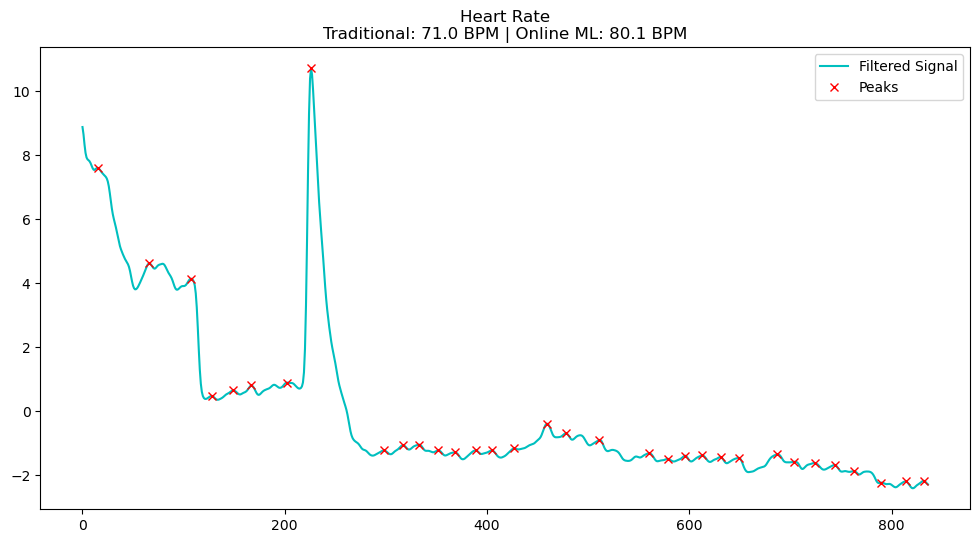

In [13]:
import cv2
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import time
import os
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib

# Configuration
MODEL_FILE = 'ppg_online_model.pkl'
SCALER_FILE = 'ppg_scaler.pkl'
WINDOW_SIZE = 90
STEP_SIZE = 45
MIN_SAMPLES = 5

def record_video(filename='ppg_capture.avi', duration=30, fps=30):
    cap = cv2.VideoCapture(0)
    width, height = int(cap.get(3)), int(cap.get(4))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    print(f"Recording for {duration} seconds. Cover camera with your fingertip.")
    start_time = time.time()
    
    while (time.time() - start_time) < duration:
        ret, frame = cap.read()
        if not ret: break
        remaining = max(0, int(duration - (time.time() - start_time)))
        cv2.putText(frame, f"Recording: {remaining}s", 
                   (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
        out.write(frame)
        cv2.imshow('Recording (Press Q to stop)', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'): break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()

def process_signal(signal, fps):
    nyq = 0.5 * fps
    b, a = butter(2, [0.5/nyq, 4.0/nyq], btype='band')
    filtered = filtfilt(b, a, signal)
    return (filtered - np.mean(filtered)) / np.std(filtered)

def extract_features(signal, fps):
    processed = process_signal(signal, fps)
    features = []
    
    for i in range(0, len(processed) - WINDOW_SIZE, STEP_SIZE):
        window = processed[i:i+WINDOW_SIZE]
        fft = np.abs(np.fft.fft(window))
        freqs = np.fft.fftfreq(len(window), 1/fps)
        
        features.append([
            np.mean(window),
            np.std(window),
            freqs[np.argmax(fft)],
            np.sum(fft**2),
            len(find_peaks(window)[0]),
            np.percentile(window, 75)
        ])
    
    return np.array(features)

def load_or_init_model():
    if os.path.exists(MODEL_FILE) and os.path.exists(SCALER_FILE):
        model = joblib.load(MODEL_FILE)
        scaler = joblib.load(SCALER_FILE)
        print("Loaded existing model")
    else:
        scaler = StandardScaler()
        model = make_pipeline(
            scaler,
            SGDRegressor(
                learning_rate='adaptive',
                eta0=0.01,
                power_t=0.25,
                warm_start=True
            )
        )
        print("Initialized new model")
    return model, scaler

def get_ground_truth():
    return np.random.uniform(60, 100)  # Replace with real sensor input

if __name__ == "__main__":
    # 1. Record new data
    record_video(duration=30)
    
    # 2. Proper frame reading with validation
    cap = cv2.VideoCapture('ppg_capture.avi')
    blue_signal = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        blue_signal.append(np.mean(frame[:, :, 0]))
    
    cap.release()
    blue_signal = np.array(blue_signal)
    
    # 3. Feature extraction
    X_new = extract_features(blue_signal, fps=30)
    if len(X_new) < MIN_SAMPLES:
        raise ValueError(f"Need at least {MIN_SAMPLES} windows. Got {len(X_new)}")
    
    # 4. Get ground truth
    y_new = np.array([get_ground_truth() for _ in range(len(X_new))])
    
    # 5. Online learning
    model, scaler = load_or_init_model()
    
    if hasattr(model, 'partial_fit'):
        X_scaled = scaler.transform(X_new) if hasattr(scaler, 'mean_') else scaler.fit_transform(X_new)
        model.named_steps['sgdregressor'].partial_fit(X_scaled, y_new)
    else:
        model.fit(X_new, y_new)
    
    joblib.dump(model, MODEL_FILE)
    joblib.dump(scaler, SCALER_FILE)
    
    # 6. Traditional method
    smoothed = gaussian_filter1d(blue_signal - np.mean(blue_signal), 2)
    peaks, _ = find_peaks(smoothed, distance=15)
    trad_bpm = len(peaks) / (len(blue_signal)/30) * 60
    
    # 7. ML prediction
    X_all = extract_features(blue_signal, fps=30)
    ml_bpm = model.predict(X_all.mean(0).reshape(1, -1))[0]
    
    # 8. Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(smoothed, 'c', label='Filtered Signal')
    plt.plot(peaks, smoothed[peaks], 'rx', label='Peaks')
    plt.title(f"Heart Rate\nTraditional: {trad_bpm:.1f} BPM | Online ML: {ml_bpm:.1f} BPM")
    plt.legend()
    plt.show()